### Reader

In [ ]:
import os
import xml.etree.ElementTree as ET
cache_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache'
filenames = [filename for filename in os.listdir(cache_path) if filename.endswith('tei.xml')]


def get_full_text(element):
    text = element.text or ''
    for subelement in element:
        text += ET.tostring(subelement, encoding='unicode', method='text')
        if subelement.tail:
            text += subelement.tail
    return text.strip()

iter_filenames = (iter(filenames))

In [ ]:
file_path = os.path.join(cache_path, next(iter_filenames)) 
file_path

In [ ]:
file_dict = {}
tree = ET.parse(file_path)
root = tree.getroot()

namespace = {'tei': 'http://www.tei-c.org/ns/1.0'}

In [ ]:
# title
title = root.find('.//tei:teiHeader/tei:fileDesc/tei:titleStmt/tei:title', namespaces=namespace)
file_dict['title'] = title.text
file_dict

In [ ]:
# authors
authors = root.findall('.//tei:teiHeader/tei:fileDesc/tei:sourceDesc/tei:biblStruct/tei:analytic/tei:author/tei:persName', namespaces=namespace)
file_dict['authors'] = []
for author in authors:
    forename = author.findall('tei:forename', namespaces=namespace)
    if len(forename) == 0:
        continue
    forename = ' '.join(name.text for name in forename)
    surname = ' '.join([name.text for name in author.findall('tei:surname', namespaces=namespace)])
    author_name = forename + ' ' + surname
    file_dict['authors'].append(author_name)
file_dict

In [ ]:
# abstract
abstract = root.find('.//tei:teiHeader/tei:profileDesc/tei:abstract/tei:div/tei:p', namespaces=namespace)
print(abstract)
if abstract is not None:
    file_dict['abstract'] = abstract.text
file_dict

In [ ]:
# Body
body = root.findall('.//tei:text/tei:body/tei:div', namespaces=namespace)

for i, child in enumerate(body):
    ps = child.findall('.//tei:p', namespaces=namespace)
    if len(ps) == 0:
        continue
    head = child.find('.//tei:head', namespaces=namespace).text
    content = '\n'.join([get_full_text(p) for p in ps])
    file_dict[head] = content
file_dict

In [ ]:
from utils.custom_document_reader import CustomDocumentReader

documents = CustomDocumentReader(
    input_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/data",
    cache_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache",
    config_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/utils/config.json",
    remove_cache=False
)._load_data()

### CustomSplitter

In [ ]:
from llama_index.core.node_parser import SentenceSplitter

ss1 = SentenceSplitter(
    chunk_size=1024,
    include_metadata=True,
    include_prev_next_rel=True,
)

In [ ]:
from llama_index.core.storage.docstore import SimpleDocumentStore
nodes = ss1.get_nodes_from_documents(documents)
docstore = SimpleDocumentStore()
docstore.add_documents(nodes)
docstore.persist(persist_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/test.json")


In [ ]:
from llama_index.core.node_parser import SimpleFileNodeParser

nodes = SimpleFileNodeParser().get_nodes_from_documents(documents=documents)

In [ ]:
for k, v in nodes[0].to_dict().items():
    print(f"key: {k}\nvalue: {v}\n\n")

In [ ]:
from utils.custom_document_reader import CustomDocumentReader

documents = CustomDocumentReader(
    input_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/data",
    cache_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache",
    config_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/utils/config.json",
    remove_cache=False
)._load_data()

from utils.custom_parser import CustomHierarchicalNodeParser
hnp = CustomHierarchicalNodeParser.from_defaults()
hnp._parse_nodes(documents)

### Test custom document reader

In [ ]:
from utils.custom_document_reader import CustomDocumentReader

documents = CustomDocumentReader(
    input_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/data",
    cache_dir="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache",
    config_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/utils/config.json",
    remove_cache=False
)._load_data()

from utils.custom_parser import CustomHierarchicalNodeParser
hnp = CustomHierarchicalNodeParser.from_defaults()
nodes = hnp.get_nodes_from_documents(documents)

In [ ]:
len(documents)

In [ ]:
len(nodes)

In [ ]:
from utils.custom_extractor import HuggingfaceBasedExtractor, OllamaBasedExtractor, OpenAIBasedExtractor

extractor = OllamaBasedExtractor(
    model_name='sammcj/sfr-embedding-mistral:Q4_K_M',
    only_meta={'level': ['section']}
)

extractor.extract(nodes)

### Pydantic

In [ ]:
from utils.get import get_a_store
file_path = 'D:\\Projects(D)\\Fine-Tuned-GPT-2-with-articles-ground-truth\\code\\llamaIndex\\.cache\\test-gpt-4o-batch_1_parser_CustomHierarchicalNodeParser-vicuna_13b.json'
docstore = get_a_store('SimpleDocumentStore').from_persist_path(persist_path=file_path)
nodes = [node for _, node in docstore.docs.items()][:4]

In [ ]:
from custom.custom_extractor import OpenAIBasedQARExtractor
from custom.schema import QAR
from dotenv import load_dotenv

load_dotenv()
extractor = OpenAIBasedQARExtractor(
    model_name='gpt-4o',
    cache_dir='D:\\Projects(D)\\Fine-Tuned-GPT-2-with-articles-ground-truth\\code\\llamaIndex\\.cache',
    mode='immediately',
    embedding_only=True,
    only_meta=None
)

In [ ]:
outputs = extractor.extract(nodes, 'test', 'test_action', 'D:\\Projects(D)\\Fine-Tuned-GPT-2-with-articles-ground-truth\\code\\llamaIndex\\.cache')

In [ ]:
nodes[0].metadata['questions_this_excerpt_can_answer_and_corresponding_answers_and_reasons'].split('\n')

In [ ]:
nodes[0].metadata['questions_this_excerpt_can_answer_and_corresponding_answers_and_reasons'].split('\n')

In [ ]:
import re
def extract_json_str(text: str) -> list:
    """Extract JSON strings from text."""
    matches = re.findall(r'\{.*?\}', text.strip(), re.MULTILINE | re.IGNORECASE | re.DOTALL)
    if not matches:
        raise ValueError(f"Could not extract json strings from output: {text}")
    return matches

text = """```json
[
    {
        "Question": "What are the main pathological features of Parkinson's disease as described in the document?",
        "Answer": "The main pathological feature of Parkinson's disease is the progressive destruction of dopamine-producing cells in the substantia nigra region of the brain stem.",
        "Reason": "This specific detail about the pathological feature is highlighted in the context and is not general knowledge."
    },
    {
        "Question": "How does the document describe the role of neuromelanin in Parkinson's disease?",
        "Answer": "The document suggests that neuromelanin may serve as an indication of catecholamine synthesis in neuronal systems containing dopamine or norepinephrine and may influence neuronal metabolism due to the heavy metals it contains.",
        "Reason": "This insight into neuromelanin's role and its potential impact on neuronal metabolism is unique to the context provided."
    },
    {
        "Question": "What evidence does the document provide to support the hypothesis that oxidative stress is involved in Parkinson's disease?",
        "Answer": "The document provides evidence such as increased membrane peroxidation in the substantia nigra, elevated TBA-reactive substance levels, increased 8-hydroxy-2′deoxyguanosine levels, and low phospholipid turnover in the substantia nigra.",
        "Reason": "These specific pieces of evidence are detailed in the context and are not commonly known facts."
    },
    {
        "Question": "What are the potential sources of increased oxidative stress in Parkinson's disease according to the document?",
        "Answer": "Potential sources include dopamine metabolism, mitochondrial dysfunction, increased free iron levels, accumulation of AGEs, reduced activity of free radical defense systems, and the deleterious role of glial cells.",
        "Reason": "The document lists these specific sources, providing a comprehensive view that is unique to the context."
    },
    {
        "Question": "How does the document describe the involvement of mitochondrial dysfunction in Parkinson's disease?",
        "Answer": "The document describes mitochondrial dysfunction as involving abnormalities of the respiratory chain, particularly a 30-40% decrease in complex I activity in the substantia nigra, which leads to reductions in ATP production and elevated ROS generation.",
        "Reason": "This detailed description of mitochondrial dysfunction and its specific impact on Parkinson's disease is unique to the context provided."
    }
]
"""

for k in extract_json_str(text):
    print(k)
# print(extract_json_str(text))

### Custom IO nodes

In [ ]:
from llama_index.core.storage.docstore import SimpleDocumentStore
docstore = SimpleDocumentStore.from_persist_path(persist_path="/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/test_2_parser_CustomHierarchicalNodeParser-ollama_vicuna_13b.json")
nodes = [node for _, node in docstore.docs.items()]

In [ ]:
from llama_index.core.schema import TextNode
TextNode.from_dict(nodes[0].to_dict())

In [ ]:
len(nodes)

In [ ]:
nodes[0].get_content()

In [ ]:
import os, sys
root_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
sys.path.insert(0, root_dir)

In [ ]:
import os
import json
from typing import List
from tqdm import tqdm
from llama_index.core.schema import BaseNode, TextNode

def save_nodes_jsonl(file_path: str, nodes: List[BaseNode]):
    try:
        with open(file_path, 'w') as file:
            for node in tqdm(nodes, desc='Saving nodes...'):
                json.dump(node.to_dict(), file)
                file.write('\n')
    except Exception as e:
        print(f"An error occurred while saving nodes: {e}")

def load_nodes_jsonl(file_path: str) -> List[TextNode]:
    nodes = []
    
    try:
        # Get the total file size
        file_size = os.path.getsize(file_path)
        
        # Read the file and track progress based on bytes read
        with open(file_path, 'r') as file:
            with tqdm(total=file_size, desc='Loading nodes...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
                for line in file:
                    node_data = json.loads(line)
                    nodes.append(TextNode.from_dict(node_data))
                    # Update progress bar based on bytes read
                    pbar.update(len(line))
    except Exception as e:
        print(f"An error occurred while loading nodes: {e}")
    
    return nodes


In [ ]:
file_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/test.jsonl'
save_nodes_jsonl(file_path, nodes)

In [ ]:
nodes = load_nodes_jsonl(file_path)
print(len(nodes))

### get pocessing node id

In [ ]:
import os
file_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/pid-20.jsonl'
nodes = load_nodes_jsonl(file_path)

In [ ]:
_cache_process_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/pid-20.jsonl'
latest_level = -1
_level2nodes = {}
level2int = {level: i for i, level in enumerate(["document", "section", "paragraph", "multi-sentences"])}

In [ ]:
cache_file = open(_cache_process_path, 'r')

In [ ]:
if os.path.exists(_cache_process_path):
    file_size = os.path.getsize(_cache_process_path)
    i = 1
    with open(_cache_process_path, 'r') as cache_file:
        with tqdm(total=file_size, desc='Loading cache...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
            for line in cache_file:
                try:
                    node_dict = json.loads(line)
                    node = TextNode.from_dict(node_dict)
                    if level2int[node.metadata['level']] > latest_level:
                        latest_level = level2int[node.metadata['level']]
                        _level2nodes[latest_level] = []
                    _level2nodes[level2int[node.metadata['level']]].append(node)
                except Exception as e:
                    print(e)
                # Update progress bar based on bytes read
                pbar.update(len(line))
                i += 1

In [ ]:
print(_level2nodes)

In [ ]:
level = 0
processed_prev_level_nodes_id = set()
for node in _level2nodes[level]:
    processed_prev_level_nodes_id.add(node.ref_doc_id)
prev_level_nodes = []
for node in nodes:
    if node.id_ not in processed_prev_level_nodes_id:
        prev_level_nodes.append(node)

In [ ]:
print(len(processed_prev_level_nodes_id))

In [ ]:

def _init_get_nodes_from_nodes(nodes):
        latest_level = 0
        prev_level_nodes = nodes
        _cache_process_path = '/home/zhengzheng/scratch0/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/pid-0.jsonl'

        if _cache_process_path is not None:
            # init attributions
            latest_level = -1
            _level2nodes = {}
            level2int = {level: i for i, level in enumerate(["document", "section", "paragraph", "multi-sentences"])}
            
            # loading nodes
            if os.path.exists(_cache_process_path):
                file_size = os.path.getsize(_cache_process_path)
                with open(_cache_process_path, 'r') as cache_file:
                    with tqdm(total=file_size, desc='Loading cache...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
                        for line in cache_file:
                            try:
                                node_dict = json.loads(line)
                                node = TextNode.from_dict(node_dict)
                                if level2int[node.metadata['level']] > latest_level:
                                    latest_level = level2int[node.metadata['level']]
                                    _level2nodes[latest_level] = []
                                    _level2nodes[latest_level].append(node)
                            except Exception as e:
                                print(e)
                            # Update progress bar based on bytes read
                            pbar.update(len(line))
            _cache_process_file = open(_cache_process_path, 'a+')

            latest_level = max(latest_level, 0)

            # get prev_level_nodes
            if latest_level == 1:
                latest_level = 0
                processed_prev_level_nodes_id = set()
                for node in _level2nodes[latest_level]:
                    processed_prev_level_nodes_id.add(node.ref_doc_id)
                prev_level_nodes = []
                for node in nodes:
                    if node.id_ not in processed_prev_level_nodes_id:
                        prev_level_nodes.append(node)
                
            if latest_level > 1:
                processed_prev_level_nodes_id = set()
                for node in _level2nodes[latest_level]:
                    parent_node_id = node.relationships[NodeRelationship.PARENT].node_id
                    processed_prev_level_nodes_id.add(parent_node_id)
                prev_level_nodes = []
                for node in _level2nodes[latest_level-1]:
                    if node.id_ not in processed_prev_level_nodes_id:
                        prev_level_nodes.append(node)

        return latest_level, prev_level_nodes

In [ ]:
from llama_index.core.schema import BaseNode, Document, NodeRelationship

print(nodes[-1].relationships[NodeRelationship.PARENT])

In [ ]:
len(processed_section_nodes_id)

In [ ]:
node_dict.keys()

In [ ]:
len(node_dict['paragraph'])

In [ ]:
len(node_dict['section'])

### Visualize node parser results

In [1]:
import os, sys
root_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
sys.path.insert(0, root_dir)
import os
import json
from typing import List
from tqdm import tqdm
from llama_index.core.schema import BaseNode, TextNode

def save_nodes_jsonl(file_path: str, nodes: List[BaseNode]):
    try:
        with open(file_path, 'w') as file:
            for node in tqdm(nodes, desc='Saving nodes...'):
                json.dump(node.to_dict(), file)
                file.write('\n')
    except Exception as e:
        print(f"An error occurred while saving nodes: {e}")

def load_nodes_jsonl(file_path: str) -> List[TextNode]:
    nodes = []
    
    try:
        # Get the total file size
        file_size = os.path.getsize(file_path)
        
        # Read the file and track progress based on bytes read
        with open(file_path, 'r') as file:
            with tqdm(total=file_size, desc='Loading nodes...', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
                for line in file:
                    node_data = json.loads(line)
                    nodes.append(TextNode.from_dict(node_data))
                    # Update progress bar based on bytes read
                    pbar.update(len(line))
    except Exception as e:
        print(f"An error occurred while loading nodes: {e}")
    
    return nodes

In [17]:
# file_path = r'D:\Projects(D)\Fine-Tuned-GPT-2-with-articles-ground-truth\code\llamaIndex\.cache\target_nodes.jsonl'
# file_path = 'D:\Projects(D)\Fine-Tuned-GPT-2-with-articles-ground-truth\code\llamaIndex\.cache\gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_processing.jsonl'
# file_path = r'/scratch0/zhengzheng/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.save/gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_1.jsonl'
file_path = '/scratch0/zhengzheng/projects/Fine-Tuned-GPT-2-with-articles-ground-truth/code/llamaIndex/.cache/gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_50_pid_0.jsonl'
nodes = load_nodes_jsonl(file_path)

Loading nodes...: 100%|██████████| 141M/141M [00:03<00:00, 41.3MB/s] 


In [18]:
import pandas as pd
import numpy as np
section_titles = []
ids = []
levels = []
texts = []
text_lens = []
parent_ids = []
id2nodes = {}
parent_id_counts = {}
parent_id_sum_len = {}
for node in nodes:
    id2nodes[node.id_] = node
    ids.append(node.id_)
    level = node.metadata['level']
    parent_id = node.ref_doc_id
    text = node.get_content()

    levels.append(level)
    parent_ids.append(parent_id)
    texts.append(text)
    text_lens.append(len(text))
    if node.metadata['level'] == 'section':
        section_titles.append(node.metadata['section_title'].lower())
    else:
        section_titles.append(None)

    if parent_id not in parent_id_counts:
        parent_id_counts[parent_id] = 0
    parent_id_counts[parent_id] += 1

    if parent_id not in parent_id_sum_len:
        parent_id_sum_len[parent_id] = 0
    if level in ['paragraph', 'multi-sentences']:
        parent_id_sum_len[parent_id] += len(text)
    else:
        parent_id_sum_len[parent_id] += len(node.metadata['original_content'])
df = pd.DataFrame({
    'id': ids,
    'level': levels,
    'text': texts,
    'text_len': text_lens,
    'parent_id': parent_ids,
    'section_titles': section_titles
})
df['child_num'] = df['id'].map(parent_id_counts)

df['diff_text_len_sum_children_len'] = np.nan
for idx, row in df.iterrows():
    if row['id'] in parent_id_sum_len:
        node = id2nodes[row['id']]
        if node.metadata['level'] == 'document':
            df.at[idx, 'diff_text_len_sum_children_len'] = len(node.metadata['original_content']) - parent_id_sum_len[row['id']]
        if node.metadata['level'] == 'section':
            df.at[idx, 'diff_text_len_sum_children_len'] = len(node.metadata['original_content']) - parent_id_sum_len[row['id']]
        elif node.metadata['level'] == 'paragraph':
            df.at[idx, 'diff_text_len_sum_children_len'] = len(node.text) - parent_id_sum_len[row['id']]

In [4]:
df

,id,level,text,text_len,parent_id,section_titles,child_num,diff_text_len_sum_children_len
0,af963dcf-8376-4b71-9c2a-73fa5b20bd3d,document,The study examines why some soybean seeds rema...,366,5835daab-2c6b-4a14-a983-f4e9bed92177,None,17.0,1422.0
1,d06e9c99-c05c-4afb-9266-dba9d068a210,document,The production of healthy sweeteners has gaine...,423,68b49ce0-40d2-40e0-ae57-36343c9979f8,None,12.0,1008.0
2,bf29316d-4f39-4e27-a4f8-fcc90ad2bfc2,document,This study explores using de-oiled algal bioma...,347,c8bc8c61-dc32-4224-893e-3873a769b351,None,8.0,948.0
3,64c2edd8-11e6-4164-946e-3116c4676892,document,This research presents an upgraded version of ...,309,d8faa86b-c247-451f-b224-00ec1cf398d4,None,5.0,1425.0
4,54fe855b-f888-496c-b179-2a331ddfc2df,document,Cellulases play a crucial role in transforming...,233,420f66f0-3ba1-4370-b6ea-e651f8c6b24d,None,26.0,1256.0
...,...,...,...,...,...,...,...,...
8804,14a26869-2457-4dd8-b75f-b2a3155e0b9b,multi-sentences,The key considerations for choosing the most s...,247,e2cb07a5-7356-47bf-9b06-792383a2b973,None,NaN,NaN
8805,281726b6-f7af-4f52-b567-58ff568c2783,multi-sentences,Key consideration are: target market for the f...,699,e2cb07a5-7356-47bf-9b06-792383a2b973,None,NaN,NaN
8806,f89bdc77-bde0-49cc-ab9f-2b8dcf113dee,multi-sentences,with few changes for details specific to SCO p...,56,e2cb07a5-7356-47bf-9b06-792383a2b973,None,NaN,NaN
8807,6e57f66f-978d-4840-b546-1b16addd3398,multi-sentences,with few changes for details specific to SCO p...,756,e2cb07a5-7356-47bf-9b06-792383a2b973,None,NaN,NaN


In [10]:
df_filtered = df[~df['diff_text_len_sum_children_len'].isna()]

# Further filter rows where the absolute value of 'diff_text_len_sum_children_len' is greater than 800
df_large_diff = df_filtered[abs(df_filtered['diff_text_len_sum_children_len']) > 800]
df_large_diff

,id,level,text,text_len,parent_id,section_titles,parent_id_num,diff_text_len_sum_children_len
1,1afa3420-36ca-44e3-9c70-96779dce6c91,document,The article highlights the significance of opt...,441,1bd51770-43d3-4ae0-be19-0856ad270790,None,1,1614.0
3,56eabac7-8098-4427-8836-ac323e92d31b,document,Researchers examined the N-glycans of cell-wal...,439,f2efe430-66d8-4061-b48c-1e73a9c3a52d,None,1,1020.0
4,1422854f-c275-4872-a4df-1d2eb73691e3,document,This research explores the impact of gonadotro...,401,237627e5-fcc7-4ead-beab-6540a4868206,None,1,2057.0
7,776aaef7-578e-472c-a06a-f4e8e0a1c025,document,The article explores the relationship between ...,404,d51746d9-ab62-44c6-81b4-6d0509df364c,None,1,1425.0
8,0a6f91e5-e090-4c10-aaee-875f92938da9,document,1. This study investigated the structural and ...,499,824348ff-6b8e-4928-8dfc-fe0fb8f1fbc0,None,1,1095.0
...,...,...,...,...,...,...,...,...
193,2c7f1615-8c20-4942-bb2a-e2ce1938fb87,document,The study examines the impact of two pentaosid...,377,6f909634-cdd8-4603-90ac-8e91529654b4,None,1,921.0
195,bf835baa-fdea-4657-b372-16383b30b703,document,This study explores the LbL process for creati...,463,8d7c4283-7e45-491c-8f9b-41cbfd48bfbb,None,1,1167.0
196,092060c6-796e-4942-9174-ab3f4f06d5b6,document,The study examined the effectiveness of plant ...,301,8f3608d4-1676-4069-acb2-29e1df0f4111,None,1,824.0
197,e99b2371-450b-44b4-aa28-229b3ba74d5d,document,Researchers explored using chitosan sulfates i...,482,7118d2c7-16e9-444d-acb8-85680d19be51,None,1,1031.0


In [ ]:
df[df['level'] == 'section']['section_titles'].value_counts()[:10]

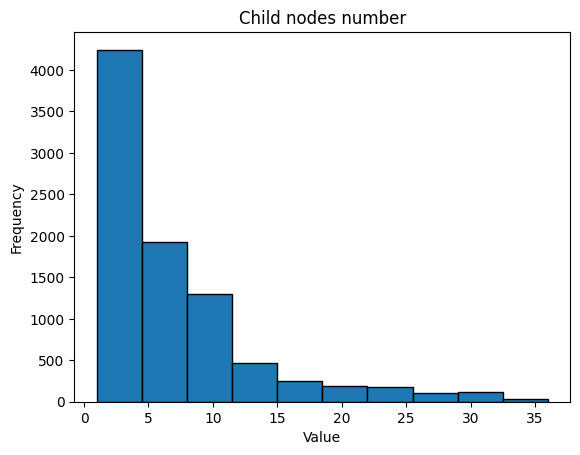

In [43]:
import matplotlib.pyplot as plt

# df_filtered = df[~df['diff_text_len_sum_children_len'].isna()]
# plt.hist(df_filtered['diff_text_len_sum_children_len'], bins=10, edgecolor='black')
# 绘制直方图
# plt.hist(df['diff_text_len_sum_children_len'], bins=10, edgecolor='black')

plt.hist(df['child_num'], bins=10, edgecolor='black')


# 添加标题和标签
plt.title('Child nodes number')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()

In [16]:
new_df = df[df['level'] == 'document']
sum(new_df['diff_text_len_sum_children_len'] == 0)

0

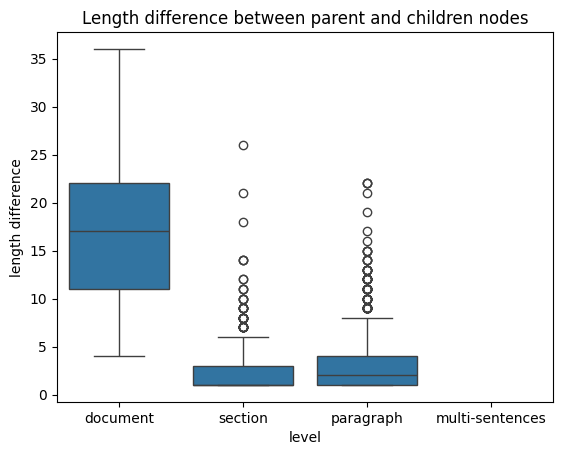

In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create a violin plot
# sns.violinplot(x='level', y='child_num', data=df)

# # Add titles and labels
# plt.title('Length difference between parent and children nodes')
# plt.xlabel('level')
# plt.ylabel('length difference')

# # Show the plot
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot
sns.boxplot(x='level', y='child_num', data=df, showfliers=True)

# Add titles and labels
plt.title('Length difference between parent and children nodes')
plt.xlabel('level')
plt.ylabel('length difference')

# Show the plot
plt.show()

In [8]:
df['level'].value_counts()

level
section            1264
paragraph          1059
multi-sentences     977
document            200
Name: count, dtype: int64

### Model for sentence classification

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path='D:\Projects(D)\Fine-Tuned-GPT-2-with-articles-ground-truth\code\llamaIndex\.env')
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# load from local
token = os.getenv('GLYCO_TOKEN')
sentence_model = AutoModelForSequenceClassification.from_pretrained("MomochiKyaru/glyco-paper-sentence",token=token)
paragraph_model = AutoModelForSequenceClassification.from_pretrained("MomochiKyaru/glyco-paper-paragraph", token=token)
tokenizer =AutoTokenizer.from_pretrained('MomochiKyaru/glyco-paper-sentence',token=token)

In [ ]:
def get_sentence_prediction(text):
    tokenized_input = tokenizer(text,truncation=True, padding=True, return_tensors='pt')
    logits = sentence_model(**tokenized_input).logits
    probabilities = logits.softmax(dim=1)
    return probabilities.detach().numpy()

In [ ]:
print(df.iloc[0]['abstract'])
print(get_sentence_prediction(df.iloc[0]['abstract']))

### Evaluate

In [1]:
from datasets import load_dataset

# loading the V2 dataset
amnesty_qa = load_dataset("explodinggradients/amnesty_qa", "english_v2")
amnesty_qa

ModuleNotFoundError: No module named 'datasets'

In [3]:
from datasets import load_dataset

# loading the V2 dataset
amnesty_qa = load_dataset("explodinggradients/amnesty_qa", "english_v2", trust_remote_code=True)
amnesty_qa

Repo card metadata block was not found. Setting CardData to empty.
Generating eval split: 20 examples [00:00, 1666.59 examples/s]


DatasetDict({
    eval: Dataset({
        features: ['question', 'ground_truth', 'answer', 'contexts'],
        num_rows: 20
    })
})

In [7]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from ragas import evaluate

result = evaluate(
    amnesty_qa["eval"],
    metrics=[
        # context_precision,
        faithfulness,
        # answer_relevancy,
        # context_recall,
    ],
)

result

ValidationError: 1 validation error for ChatOpenAI
__root__
  Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. (type=value_error)